<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/MLFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data With  Request To GitHub And Read Columns From CSV

In [8]:
import pandas as pd
import requests
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

url="https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/Fraud_Data.csv"
s=requests.get(url).content
#,usecols=["user_id","device_id","source","browser","purchase_value","sex","age","class","ip_address"]
c=pd.read_csv(io.StringIO(s.decode('utf-8')),sep = ",")




Fill Country Information From Ip Address

In [9]:
IP_table = pd.read_csv("https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/IpAddress_to_Country.csv")   # Country from IP information

# We want to get country related to each IP address
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
c.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"
c["ip_country"] = c.ip_address.apply(IP_to_country)

Data Enrichment

In [10]:
c['day_diff_purchase_signup'] = (pd.to_datetime(c['purchase_time']) - pd.to_datetime(c['signup_time'])).dt.days
device_dict = dict(c.device_id.value_counts())
ip_dict = dict(c.ip_address.value_counts())
# assign that dict to a column
c['device_TranCount'] = [device_dict[d] for d in c.device_id]
c['ip_TranCount'] = [ip_dict[d] for d in c.ip_address]
c['is_first_day_tran']= np.where(c['day_diff_purchase_signup'].between(0,0), 1, 0)
c['age_0_20']= np.where(c['age'].between(0,20), 1, 0)
c['age_21_40']= np.where(c['age'].between(21,40), 1,0)
c['age_41_60']= np.where(c['age'].between(41,60), 1, 0)
c['age_61_100']= np.where(c['age'].between(61,100), 1, 0)

c['amount_0_20']= np.where(c['purchase_value'].between(0,20), 1, 0)
c['amount_21_40']= np.where(c['purchase_value'].between(21,40), 1,0)
c['amount_41_60']= np.where(c['purchase_value'].between(41,60), 1, 0)
c['amount_61_100']= np.where(c['purchase_value'].between(61,100), 1, 0)
c['amount_101_10000']= np.where(c['purchase_value']>100, 1, 0)
c.head(10)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country,day_diff_purchase_signup,device_TranCount,ip_TranCount,is_first_day_tran,age_0_20,age_21_40,age_41_60,age_61_100,amount_0_20,amount_21_40,amount_41_60,amount_61_100,amount_101_10000
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52,1,1,0,0,1,0,0,0,1,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,1,1,1,0,0,1,0,1,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,12,12,1,0,0,1,0,1,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,5,1,1,0,0,0,1,0,0,0,1,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50,1,1,0,0,0,1,0,0,1,0,0,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,49,1,1,0,1,0,0,0,0,0,1,0,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,Unknown,25,1,1,0,1,0,0,0,1,0,0,0,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States,49,1,1,0,0,1,0,0,0,1,0,0,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China,41,1,1,0,0,0,1,0,0,1,0,0,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States,57,1,1,0,0,1,0,0,0,0,0,1,0


One Hot Encoding For Categories

In [13]:
# use pd.concat to join the new columns with your original dataframe
c = pd.concat([c,pd.get_dummies(c['sex'], prefix='sex')],axis=1)
c = pd.concat([c,pd.get_dummies(c['browser'], prefix='browser')],axis=1)
c = pd.concat([c,pd.get_dummies(c['source'], prefix='source')],axis=1)
c = pd.concat([c,pd.get_dummies(c['ip_country'], prefix='county')],axis=1)




Drop Unnecessary Columns

Split Test And Training Data

In [14]:
c.drop(['purchase_time','user_id','signup_time','device_id','ip_address','sex','browser','source','ip_country'],axis=1, inplace=True)

#c.drop(['age','purchase_value','day_diff_purchase_signup','user_id','purchase_time','signup_time','sex','browser','source','device_id','ip_address'],axis=1, inplace=True)
col = c.pop("class")
c.insert(len(c.columns), col.name, col)
c.head(10)


,purchase_value,age,day_diff_purchase_signup,device_TranCount,ip_TranCount,is_first_day_tran,age_0_20,age_21_40,age_41_60,age_61_100,amount_0_20,amount_21_40,amount_41_60,amount_61_100,amount_101_10000,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,county_Afghanistan,county_Albania,county_Algeria,county_Angola,county_Antigua and Barbuda,...,county_San Marino,county_Saudi Arabia,county_Senegal,county_Serbia,county_Seychelles,county_Singapore,county_Slovakia (SLOVAK Republic),county_Slovenia,county_South Africa,county_South Sudan,county_Spain,county_Sri Lanka,county_Sudan,county_Sweden,county_Switzerland,county_Syrian Arab Republic,county_Taiwan; Republic of China (ROC),county_Tajikistan,county_Tanzania United Republic of,county_Thailand,county_Trinidad and Tobago,county_Tunisia,county_Turkey,county_Turkmenistan,county_Uganda,county_Ukraine,county_United Arab Emirates,county_United Kingdom,county_United States,county_Unknown,county_Uruguay,county_Uzbekistan,county_Vanuatu,county_Venezuela,county_Viet Nam,county_Virgin Islands (U.S.),county_Yemen,county_Zambia,county_Zimbabwe,class
0,34,39,52,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,53,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15,53,0,12,12,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,44,41,5,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,39,45,50,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,42,18,49,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,11,19,25,1,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,27,34,49,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,30,43,41,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,62,31,57,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
c.describe()

,purchase_value,age,day_diff_purchase_signup,device_TranCount,ip_TranCount,is_first_day_tran,age_0_20,age_21_40,age_41_60,age_61_100,amount_0_20,amount_21_40,amount_41_60,amount_61_100,amount_101_10000,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,county_Afghanistan,county_Albania,county_Algeria,county_Angola,county_Antigua and Barbuda,...,county_San Marino,county_Saudi Arabia,county_Senegal,county_Serbia,county_Seychelles,county_Singapore,county_Slovakia (SLOVAK Republic),county_Slovenia,county_South Africa,county_South Sudan,county_Spain,county_Sri Lanka,county_Sudan,county_Sweden,county_Switzerland,county_Syrian Arab Republic,county_Taiwan; Republic of China (ROC),county_Tajikistan,county_Tanzania United Republic of,county_Thailand,county_Trinidad and Tobago,county_Tunisia,county_Turkey,county_Turkmenistan,county_Uganda,county_Ukraine,county_United Arab Emirates,county_United Kingdom,county_United States,county_Unknown,county_Uruguay,county_Uzbekistan,county_Vanuatu,county_Venezuela,county_Viet Nam,county_Virgin Islands (U.S.),county_Yemen,county_Zambia,county_Zimbabwe,class
count,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,...,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.00000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,56.609799,1.684367,1.602719,0.057957,0.059790,0.740874,0.197337,0.001999,0.211856,0.402126,0.271606,0.112566,0.001846,0.415712,0.584288,0.406533,0.162859,0.243045,0.024326,0.163237,0.396269,0.202605,0.401126,0.415712,0.584288,0.406533,0.162859,0.243045,0.024326,0.163237,0.396269,0.202605,0.401126,0.000040,0.000086,0.000807,0.000159,0.000020,...,0.000007,0.001747,0.000060,0.000457,0.000629,0.001376,0.000569,0.000576,0.005546,0.000007,0.006796,0.000205,0.000165,0.007213,0.005195,0.000159,0.008186,0.000007,0.000099,0.001926,0.000146,0.000781,0.003759,0.000007,0.000086,0.002839,0.000754,0.029713,0.384146,0.145362,0.000529,0.000066,0.000007,0.001661,0.00364,0.000020,0.000007,0.000066,0.000040,0.093646
std,18.322762,8.617733,36.142085,2.616954,2.596240,0.233663,0.237098,0.438156,0.397990,0.044660,0.408625,0.490329,0.444790,0.316062,0.042929,0.492846,0.492846,0.491188,0.369239,0.428923,0.154061,0.369583,0.489123,0.401942,0.490128,0.492846,0.492846,0.491188,0.369239,0.428923,0.154061,0.369583,0.489123,0.401942,0.490128,0.006301,0.009275,0.028402,0.012602,0.004456,...,0.002572,0.041761,0.007717,0.021364,0.025066,0.037075,0.023849,0.023988,0.074262,0.002572,0.082159,0.014321,0.012861,0.084624,0.071888,0.012602,0.090106,0.002572,0.009963,0.043841,0.012065,0.027933,0.061194,0.002572,0.009275,0.053206,0.027456,0.169795,0.486394,0.352467,0.023003,0.008135,0.002572,0.040722,0.06022,0.004456,0.002572,0.008135,0.006301,0.291336
min,9.000000,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [16]:
y = c['class']
X = c.drop(['class'], axis = 1)
# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

print(X.shape)

(151112, 409)


Random Forest Algoritm

Feature: 0, Score: 0.00603
Feature: 1, Score: 0.00257
Feature: 2, Score: 0.25877
Feature: 3, Score: 0.23109
Feature: 4, Score: 0.30929
Feature: 5, Score: 0.13974
Feature: 6, Score: 0.00102
Feature: 7, Score: 0.00012
Feature: 8, Score: 0.00030
Feature: 9, Score: 0.00001
Feature: 10, Score: 0.00038
Feature: 11, Score: 0.00011
Feature: 12, Score: 0.00014
Feature: 13, Score: 0.00016
Feature: 14, Score: 0.00001
Feature: 15, Score: 0.00025
Feature: 16, Score: 0.00039
Feature: 17, Score: 0.00016
Feature: 18, Score: 0.00005
Feature: 19, Score: 0.00310
Feature: 20, Score: 0.00001
Feature: 21, Score: 0.00033
Feature: 22, Score: 0.00215
Feature: 23, Score: 0.00152
Feature: 24, Score: 0.00041
Feature: 25, Score: 0.00003
Feature: 26, Score: 0.00041
Feature: 27, Score: 0.00013
Feature: 28, Score: 0.00038
Feature: 29, Score: 0.00022
Feature: 30, Score: 0.00138
Feature: 31, Score: 0.00022
Feature: 32, Score: 0.00144
Feature: 33, Score: 0.00226
Feature: 34, Score: 0.00076
Feature: 35, Score: 0.00000
Fe

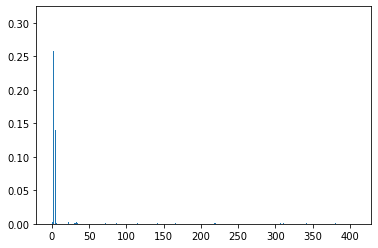

0.9584678913653449


In [17]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 5,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}
modelRF = RandomForestClassifier(**parameters)
modelRF.fit(train_X, train_y)
predictions = modelRF.predict(test_X)
score = accuracy_score(test_y ,predictions)
# get importance
importance = modelRF.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


print(score)


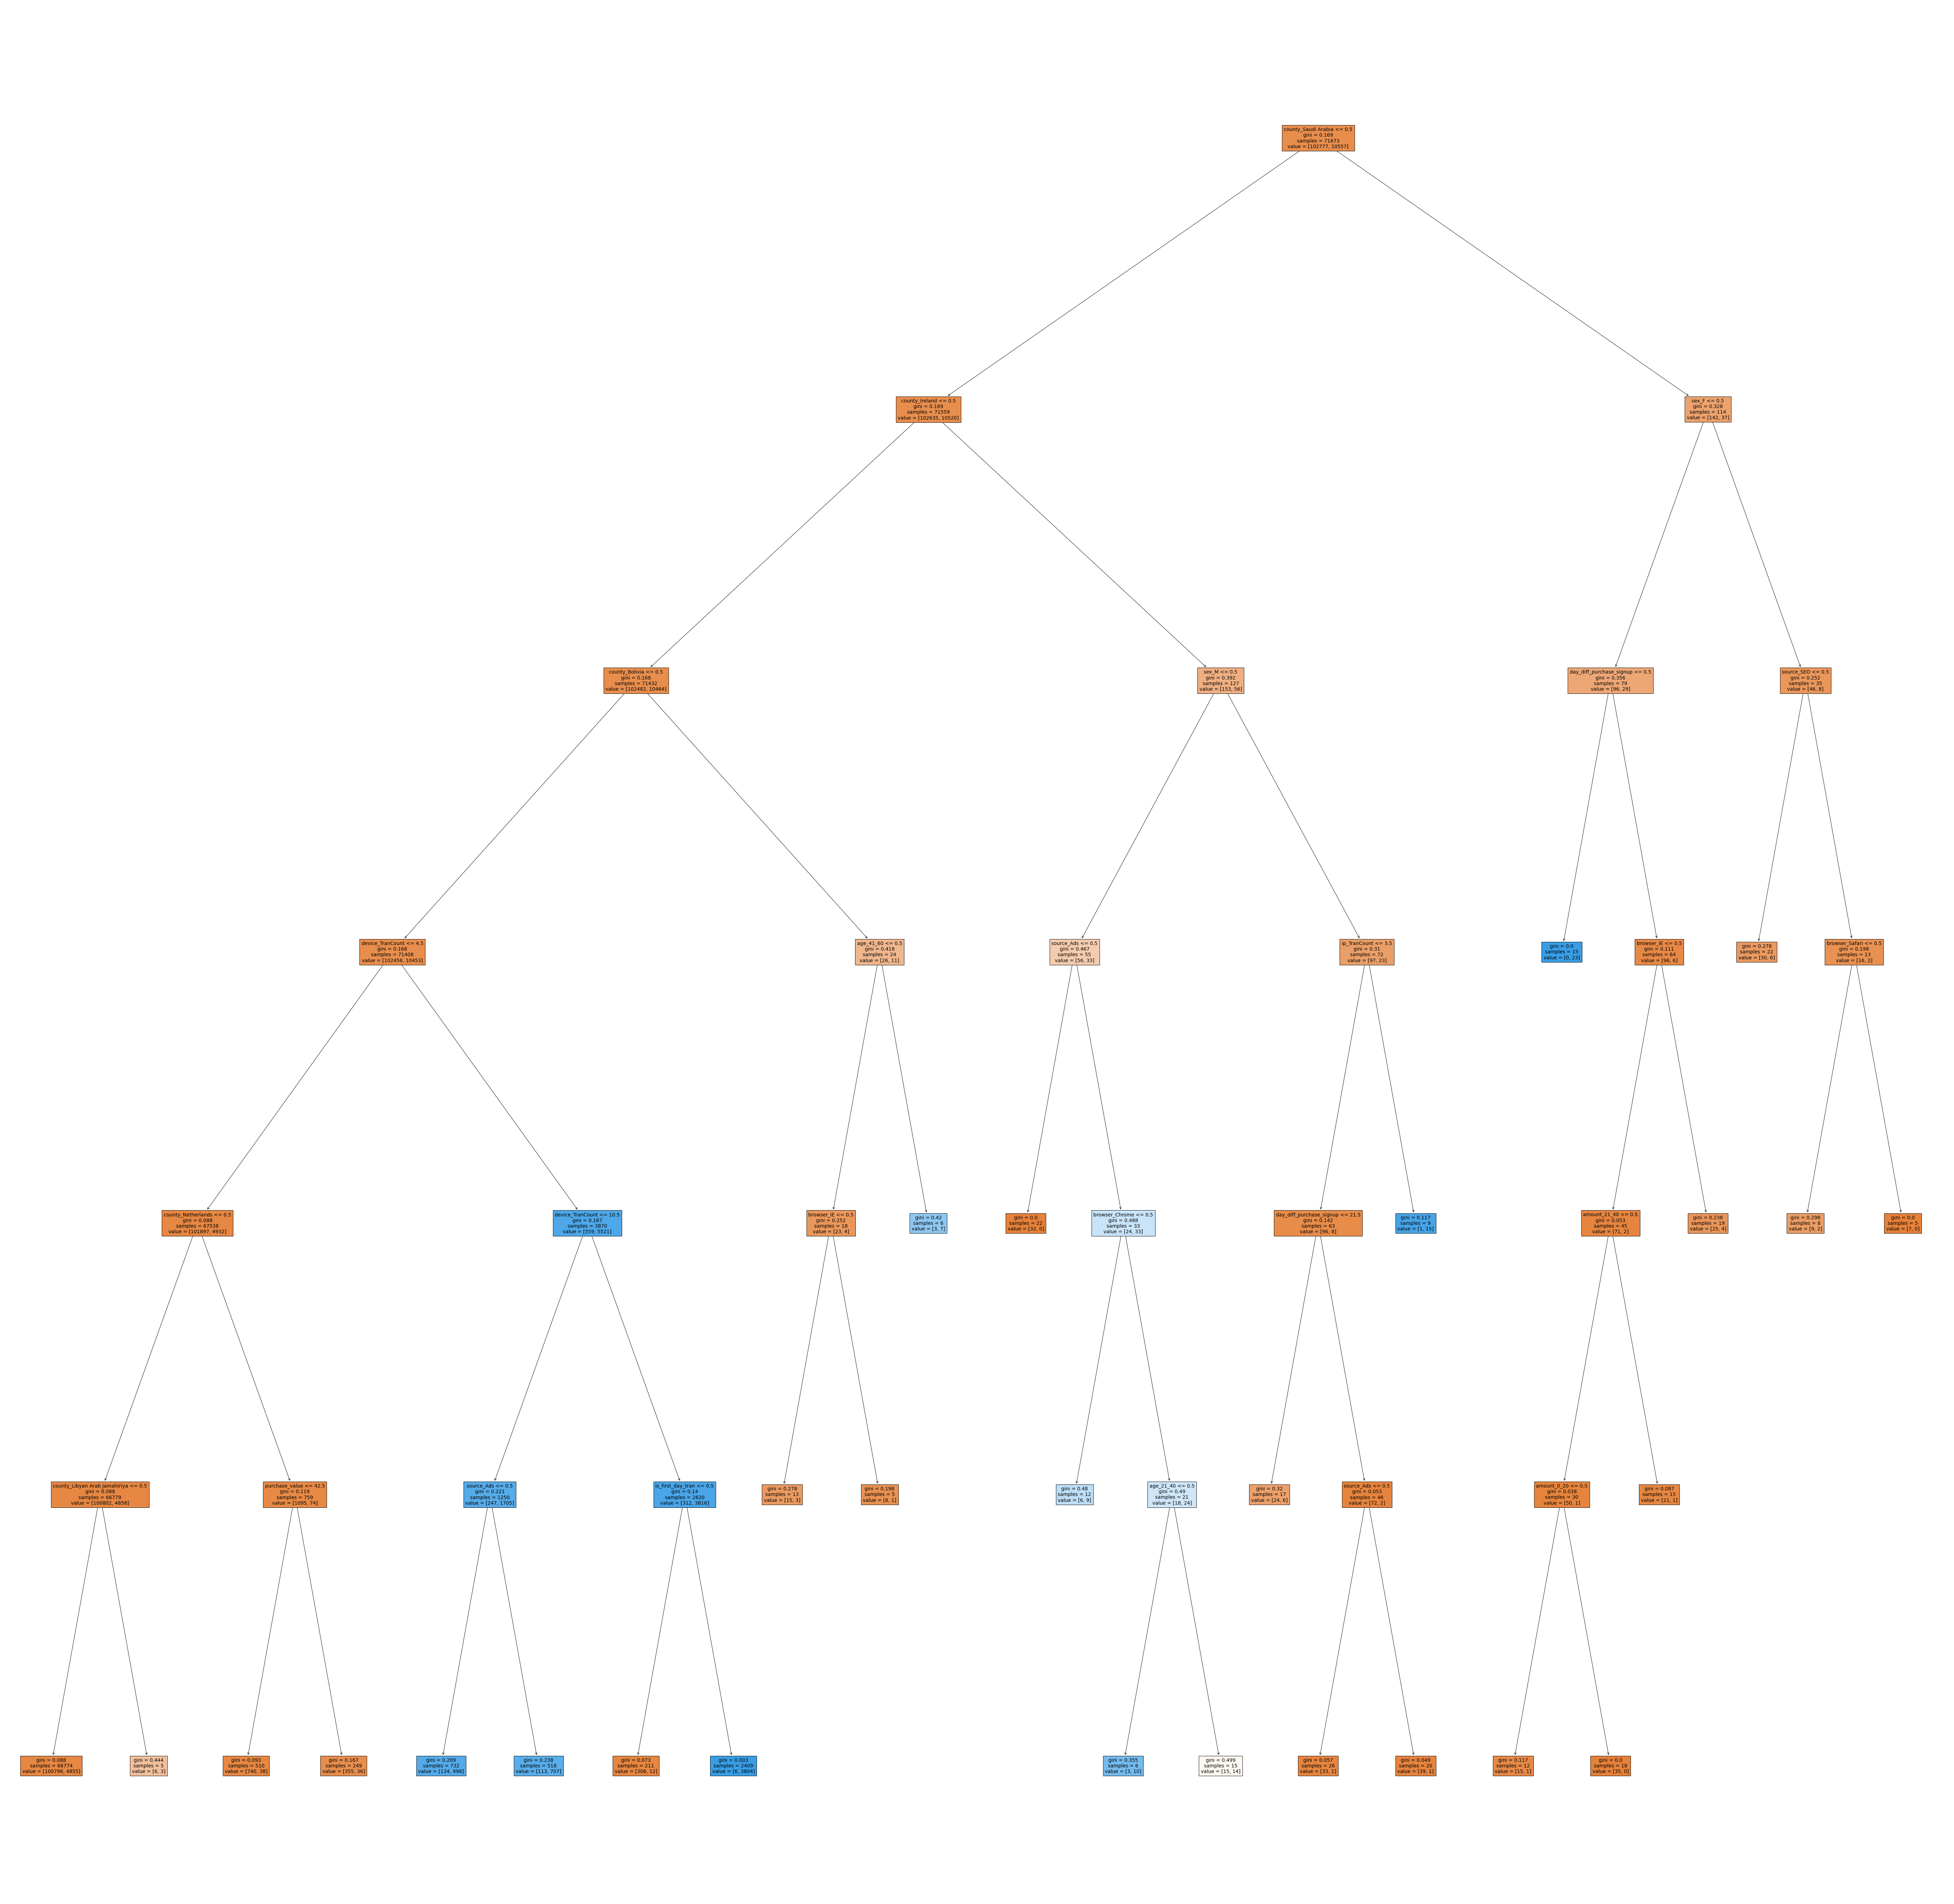

In [18]:
from sklearn import tree
from sklearn.tree import export_graphviz

estimator = modelRF.estimators_[10]

plt.figure(figsize=(100,100))
_ = tree.plot_tree(estimator, feature_names=X.columns, filled=True)
